<a href="https://colab.research.google.com/github/Rmm6699/HW/blob/master/%E3%80%8C%E6%96%87%E6%9C%AC%E6%83%85%E6%84%9F%E5%88%86%E6%9E%90_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 確認Runtime Type: GPU / CUDA

In [ ]:
!nvidia-smi

Mon Aug 23 07:09:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    83W / 149W |  11095MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 下載資料

*   檔案格式： csv (可使用 Excel 或是 Numbers 開啟)
*   [金融情感分析資料集](https://ytlin.s3.ap-northeast-1.amazonaws.com/data/finance_cls.csv)
*   [社群媒體推文情感分析資料集](https://ytlin.s3.ap-northeast-1.amazonaws.com/data/sentiment_analysis_0823.csv)

In [ ]:
!wget https://ytlin.s3.ap-northeast-1.amazonaws.com/data/sentiment_analysis_0823.csv -O sentiment_analysis_0823.csv
!wget https://ytlin.s3.ap-northeast-1.amazonaws.com/data/finance_cls.csv -O finance_cls.csv

--2021-08-23 06:45:45--  https://ytlin.s3.ap-northeast-1.amazonaws.com/data/sentiment_analysis_0823.csv
Resolving ytlin.s3.ap-northeast-1.amazonaws.com (ytlin.s3.ap-northeast-1.amazonaws.com)... 52.219.8.90
Connecting to ytlin.s3.ap-northeast-1.amazonaws.com (ytlin.s3.ap-northeast-1.amazonaws.com)|52.219.8.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73142140 (70M) [text/csv]
Saving to: ‘sentiment_analysis_0823.csv’

sentiment_analysis_ 100%[===================>]  69.75M  12.7MB/s    in 7.0s    

2021-08-23 06:45:53 (9.92 MB/s) - ‘sentiment_analysis_0823.csv’ saved [73142140/73142140]

--2021-08-23 06:45:53--  https://ytlin.s3.ap-northeast-1.amazonaws.com/data/finance_cls.csv
Resolving ytlin.s3.ap-northeast-1.amazonaws.com (ytlin.s3.ap-northeast-1.amazonaws.com)... 52.219.152.6
Connecting to ytlin.s3.ap-northeast-1.amazonaws.com (ytlin.s3.ap-northeast-1.amazonaws.com)|52.219.152.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

### 安裝函式庫

In [ ]:
!pip install -q "transformers[torch]==4.9.2" "spacy==3.1.2"
!python -m spacy download zh_core_web_md

     |████████████████████████████████| 78.8 MB 3.0 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('zh_core_web_md')


### 引入函式庫

In [ ]:
import random
from itertools import accumulate

import spacy
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from spacy.lang.zh.examples import sentences 
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

## 任務介紹

*   情感分析屬於文字分類任務。我們將使用 Recurrent Neural Network來進行文字分類
*   目標資料集包含金融情感分析、社群媒體推文情感分析。

文字情感分析（Sentiment Analysis）是自然語言處理（NLP）方法中常見的應用，是以提煉文字情緒內容為目的的分類。對帶有情感色彩的主觀性文字進行分析、處理、歸納和推理的過程。
  本文將介紹情感分析中的情感極性（傾向）分析。所謂情感極性分析，指的是對文字進行褒義、貶義、中性的判斷。在大多應用場景下，只分為兩類。例如對於“喜愛”和“厭惡”這兩個詞，就屬於不同的情感傾向。


### 資料探索-金融情感分析

In [ ]:
fin_df = pd.read_csv("./finance_cls.csv")
fin_df["sentiment"] = ["Negative" if neg else "Positive" for neg in fin_df.negative]

fin_df["label"] = [0 if neg else 1 for neg in fin_df.negative]
sentiment_mapping = {"Negative": 0, "Positive": 1}

fin_df

,id,title,text,entity,negative,key_entity,sentiment,label
0,83dcefb7,????发表了博文《【富金利】9月富金利教你如何安全提高最大化收益！》网络理财时代参与互联网...,????发表了博文《【富金利】9月富金利教你如何安全提高最大化收益！》网络理财时代参与互联网...,理财时代;富金利,0,NaN,Positive,1
1,1ad5be0d,#小资钱包涉嫌诈骗[超话]##小资钱包[超话]##迫切急待回归活命钱##头号直通中纪委[超话...,#小资钱包涉嫌诈骗[超话]##小资钱包[超话]##迫切急待回归活命钱##头号直通中纪委[超话...,小资钱包;恒丰银行,1,小资钱包;恒丰银行,Negative,0
2,6dd28e9b,?????扫黑除恶 诈骗犯齐聚海淀，保护伞根深蒂固，黑社会嚣张跋扈，出借人走投无路！ 尊敬的...,?????扫黑除恶 诈骗犯齐聚海淀，保护伞根深蒂固，黑社会嚣张跋扈，出借人走投无路！ 尊敬的...,国有投资;资易贷（北京）金融信息服务有限公司;小资钱包;资易贷,1,资易贷（北京）金融信息服务有限公司;小资钱包,Negative,0
3,1db87a14,平安银行车主贷?????? 1??期限长至48期?? 2??滴滴司机可做?? 3??白户逾期...,平安银行车主贷?????? 1??期限长至48期?? 2??滴滴司机可做?? 3??白户逾期...,平安银行;车主贷;平安银行车主贷,0,NaN,Positive,1
4,fa005713,NaN,旺旺贷跑路！深圳警方确定投资人被骗！,旺贷;旺旺贷,1,旺旺贷,Negative,0
...,...,...,...,...,...,...,...,...
4994,418e6a12,中国平安(平安普惠)客服经理林东某它妈的真烂，卧藏在平安普惠这种藏污纳垢之所，专搞诈骗营生，...,中国平安(平安普惠)客服经理林东某它妈的真烂，卧藏在平安普惠这种藏污纳垢之所，专搞诈骗营生，...,及时雨贷;平安普惠;中国平安,1,平安普惠,Negative,0
4995,a8edcf27,NaN,&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;以钱宝网事件为例，以项目年化收益...,钱宝,1,钱宝,Negative,0
4996,dfeaffb1,NaN,179.雀尚枝头+7.1号提现困难，资金链断了，现在每月返6%没有跑路,资金链;雀尚枝头+7.1号,1,雀尚枝头+7.1号,Negative,0
4997,a15b830c,#小资钱包[超话]#北京资易贷公司（“小资钱包”网贷平台）负责人潘博艺李兆民失联，是外逃了？...,#小资钱包[超话]#北京资易贷公司（小资钱包网贷平台）负责人潘博艺李兆民失联，是外逃了？还是...,小资钱包;资易贷,1,小资钱包;资易贷,Negative,0


#### 查看各類別範例

In [ ]:
for sentiment in fin_df.sentiment.unique():
  display(fin_df[fin_df.sentiment == sentiment].sample(5))

,id,title,text,entity,negative,key_entity,sentiment,label
181,06c3d78d,搜易贷P2P网贷平台2018-06-04数据报告,搜易贷P2P网贷平台2018-06-04数据报告 2018-06-05???来源：第一网贷...,搜易贷,0,NaN,Positive,1
204,d2a9c26c,有人心疼时，#京东白条提现#京东白条怎么提现#京东白条提现方法#眼泪才是眼泪，否则只是带着咸...,有人心疼时，#京东白条提现#京东白条怎么提现#京东白条提现方法#眼泪才是眼泪，否则只是带着咸...,京东白条,0,NaN,Positive,1
1841,4c1e0885,NaN,不容忽视的是，一名淘淘金的高管近日接受南都记者采访时还强调了投资者金融知识储备和对虚假标的辨...,淘淘金,0,NaN,Positive,1
3328,088b3ced,泰融理财P2P网贷平台2018/06/05数据研究,泰融理财P2P网贷平台2018/06/05数据研究 2018-06-06???来源：第一网...,泰融理财,0,NaN,Positive,1
808,08fe190f,孩子出国留学的钱有了吗？奶粉钱有了吗？钱还得挣！安心理财还是要选一点成圆！安全运营三周年，最...,孩子出国留学的钱有了吗？奶粉钱有了吗？钱还得挣！安心理财还是要选一点成圆！安全运营三周年，最...,一点成圆,0,NaN,Positive,1


,id,title,text,entity,negative,key_entity,sentiment,label
1489,b51158a4,#天津#天津源丰财富生活网络信息服务有限公司(e周行)最大受益国资企业天津渤海创投集团控股e...,#天津#天津源丰财富生活网络信息服务有限公司(e周行)最大受益国资企业天津渤海创投集团控股e...,天津源丰财富生活网络信息服务有限公司;e周行;天津渤海创投集团;渤海创投,1,天津源丰财富生活网络信息服务有限公司;e周行;天津渤海创投集团,Negative,0
4349,aca773fd,????#调查组织成都七中实验学校学生体检#终于让全国人民都知道成都有多黑了，特别是成都警察...,????#调查组织成都七中实验学校学生体检#终于让全国人民都知道成都有多黑了，特别是成都警察...,宜贷网(沪);宜贷网,1,宜贷网,Negative,0
816,618fdcc1,????#中央巡视[超话]##扫黑除恶[超话]##扫黑除恶[超话]# 放虎归山，必有后患！ ...,????#中央巡视[超话]##扫黑除恶[超话]##扫黑除恶[超话]# 放虎归山，必有后患！ ...,小资钱包;资易贷金融信息服务有限公司;易贷金融,1,小资钱包;资易贷金融信息服务有限公司,Negative,0
4708,615a9a57,????ds宜贷网易捷金融岂止假标，供链贷诈骗1.03亿，阴阳合同，拿出借人的钱去线下放高利...,????ds宜贷网易捷金融岂止假标，供链贷诈骗1.03亿，阴阳合同，拿出借人的钱去线下放高利...,宜贷网(沪);易捷金融;宜贷网,1,易捷金融;宜贷网,Negative,0
2320,ac597c54,????x宜贷网易捷金融岂止假标，供链贷诈骗1.03亿，阴阳合同，拿出借人的钱去线下放高利贷...,????x宜贷网易捷金融岂止假标，供链贷诈骗1.03亿，阴阳合同，拿出借人的钱去线下放高利贷...,宜贷网(沪);易捷金融;宜贷网,1,易捷金融;宜贷网,Negative,0


#### 文章類別數量

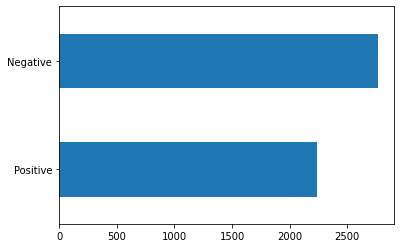

In [ ]:
fin_df.sentiment.value_counts().sort_values().plot(kind = 'barh')

#### 文章類別比例

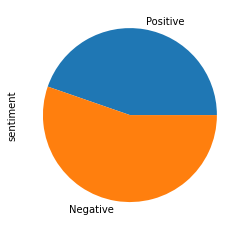

In [ ]:
fin_df.sentiment.value_counts().sort_values().plot(kind = 'pie')

#### 文章長度分佈

Text(0, 0.5, 'Frequency')

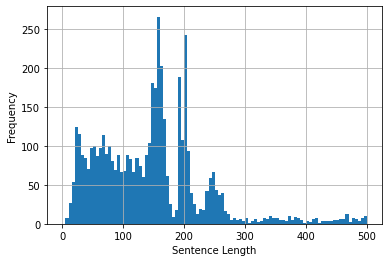

In [ ]:
fin_df.text.str.len().hist(bins=100, range=(0, 500))
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")

#### 切分 訓練集 / 測試集

In [ ]:
test_set_ratio = 0.2 #@param {type:"slider", min:0, max:0.5, step:0.05}
fin_train, fin_test = train_test_split(
    fin_df, 
    test_size=test_set_ratio, 
    random_state=42
)
print(f"Training set size: {len(fin_train)}")
print(f"Testing set size: {len(fin_test)}")

Training set size: 3999
Testing set size: 1000


### 資料探索-社群媒體推文情感分析

In [ ]:
social_df = pd.read_csv("./sentiment_analysis_0823.csv").sample(frac=0.01)
social_df = social_df.rename(columns = {'review':'text', 'mood': 'sentiment'})

eng_moods = {"喜悅": "Happy", "厭惡": "Disgusted", "憤怒": "Angry", "低落": "Depressed"}
social_df['mood_en'] = [eng_moods[mood] for mood in social_df.sentiment]

mood_mapping = {"喜悅": 0, "厭惡": 1, "憤怒": 2, "低落": 3}
social_df['label'] = [mood_mapping[mood] for mood in social_df.sentiment]


social_df

,text,sentiment,mood_en,label
172343,"Scofield 越獄越到去< 生化危機4> !?我表示狠亢奮..好想影低佢 !可惜手震了.,",低落,Depressed,3
353695,看成熬到天亮“生”啦……疼，一個人沒法去醫院，熬到天亮先。,厭惡,Disgusted,1
328432,這位老外採購商，享受到了本刊美女一對一的詳細介紹，聽的很認真吶。潘紅英（）小妞，你說的是哪國方言？,喜悅,Happy,0
10632,我阿爸阿媽就在烏魯木齊。。新疆原來這麼美！！！我要去，秋天看起來感覺好棒，現在是不是有點晚？...,低落,Depressed,3
335649,佩服挖出此帖的人【三六零必定滅騰訊】出自李白《驅鬼》萬能的詩仙李白大俠你又預言了千年後的一場...,喜悅,Happy,0
...,...,...,...,...
222748,很好！！！慵懶的週末，簡簡單單的生活,喜悅,Happy,0
341339,政治妹子有貨這是錦上添花的事，說明胸大有腦~ 關注你一個比關注一百個平胸和一千個無腦好太多太...,低落,Depressed,3
250655,突然想起我的兩張Tension 的正版CD 被借人了，並且幾乎是追不回來了……,低落,Depressed,3
193838,收到這些很無奈心痛，又如何: 字打了又改，反反覆覆，最後發出去的，已經和初始想要說的差好遠…...,低落,Depressed,3


In [ ]:
for mood in social_df.sentiment.unique():
  display(social_df[social_df.sentiment == mood].sample(5))

,text,sentiment,mood_en,label
80985,女朋友非常淑女，老媽很滿意，一次來家裡玩，老媽給女朋友看家裡的相簿，裡面有張是我滿月的照片，...,低落,Depressed,3
238382,神馬情況這……不公平啊……近日訊息，谷歌官網網站管理員中心(Webmaster Centra...,低落,Depressed,3
64719,貓仔都需要他人唧關愛......甚至比人類仲更加渴望......,低落,Depressed,3
260546,儂有房子伐？麼.....儂有車子伐？麼.....儂有票子伐？麼........,低落,Depressed,3
261593,回覆呵呵，謝謝朋友！但願吧~ ~ 明天就可以聞到“家”的味道，也是幸福的味道。讓這味道掃清心...,低落,Depressed,3


,text,sentiment,mood_en,label
223421,我TM 就是有病！幹嘛要去找那個文的名字啊！幹嘛無聊又看一遍啊！幹嘛把自己又虐一遍啊！SJB...,厭惡,Disgusted,1
330911,央視女主播：金妍兒，冬奧會女子單打花樣滑冰冠軍,厭惡,Disgusted,1
125209,物質世界越來越豐富，雖然都漲價，不都在承受嗎？但是我們的精神世界呢？我們有信仰嗎？人人都只信...,厭惡,Disgusted,1
57001,真男人，這，才是真正的不離不棄，真正的愛【一開始，我以為你是傻逼，但看到最後我要向你致敬！】,厭惡,Disgusted,1
340049,每天都想早下網可是這微博太害人上了就不想下賴上了,厭惡,Disgusted,1


,text,sentiment,mood_en,label
206765,欣賞她的生活態度：擁有40歲的EQ 和20歲的無畏無懼，擁有不怕受傷的勇氣和自由，那麼她就擁...,喜悅,Happy,0
200686,對說：丹丹，要熱 切期待啊!!~ ~ ~,喜悅,Happy,0
199891,課 室大嗎 ？哇，電腦怎麼大，應該有一百多寸吧！！！好多人，自己影自己，他們 以為 我痴線 ...,喜悅,Happy,0
137601,這個嗲嗯！可以搶 ~ 搶!哇！剛跟優衣庫的客服確認了一下，2010年11.11淘寶商城的部分...,喜悅,Happy,0
255144,我有愛的澈 兔哇￢ _ ￢ 。。。這麼牽手是要進教堂嗎,喜悅,Happy,0


,text,sentiment,mood_en,label
59174,為什麼為什麼美劇要這麼虐。。。,憤怒,Angry,2
57371,決定工作通宵了mmd,憤怒,Angry,2
41588,有時候想我不是女生多好。這樣，遇到特氣憤的事情我就可以破口大罵所以洩憤了。可是，這都不行。,憤怒,Angry,2
267137,真的嗎??!!愛阿sa 怎樣都會支援她!!!你真的相信他們 只有3個 月嗎？，其後將留言刪 ...,憤怒,Angry,2
295002,上海不是很有錢麼！無恥到頭了已經可能了聽說上海市政府在號召市民為火災捐款。,憤怒,Angry,2


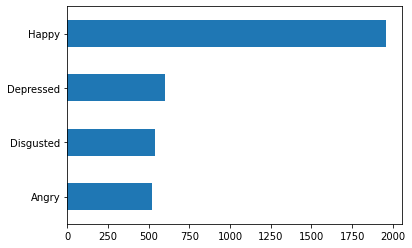

In [ ]:
social_df.mood_en.value_counts().sort_values().plot(kind = 'barh')

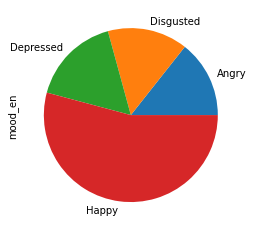

In [ ]:
social_df.mood_en.value_counts().sort_values().plot(kind = 'pie')

#### 切分 訓練集 / 測試集

In [ ]:
test_set_ratio = 0.2 #@param {type:"slider", min:0, max:0.5, step:0.05}
social_train, social_test = train_test_split(
    social_df, 
    test_size=test_set_ratio, 
    random_state=42
)
print(f"Training set size: {len(social_train)}")
print(f"Testing set size: {len(social_test)}")

Training set size: 2893
Testing set size: 724


# 模型介紹
- 大多數常見的文字分類模型使用 Recurrent Neural Network (RNN)來實作，主要是用來解決輸入長度不一樣的問題
- **Text Encoder** 是將一連串的文字編碼為單個向量，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊


![RNN](https://miro.medium.com/max/1400/0*xWfoyu6Z2ud6js1y.jpg)
![recurrent](https://img2020.cnblogs.com/blog/1439869/202101/1439869-20210125120444951-1934166239.gif)
![](https://miro.medium.com/max/1000/1*d_POV7c8fzHbKuTgJzCxtA.gif)

### RNN 簡介

### 中文斷詞

In [ ]:
nlp = spacy.load("zh_core_web_md")
doc = nlp(sentences[0])
print(doc.text+"\n")
for token in doc:
    print(token.text, token.pos_, token.dep_, sep='\t')

作为语言而言，为世界使用人数最多的语言，目前世界有五分之一人口做为母语。

作为	ADP	case
语言	NOUN	nmod:prep
而言	PART	case
，	PUNCT	punct
为	ADP	case
世界	NOUN	compound:nn
使用	NOUN	compound:nn
人数	NOUN	nsubj
最多	VERB	amod
的	PART	mark
语言	NOUN	nmod:prep
，	PUNCT	punct
目前	NOUN	nmod:tmod
世界	NOUN	dep
有	VERB	ROOT
五分之一	NUM	dep
人口	NOUN	nsubj
做为	VERB	ccomp
母语	NOUN	dobj
。	PUNCT	punct


### 文字特徵 Word Embeddings

In [ ]:
token = doc[0]
print(token.text)
print(token.vector.shape)
print(token.vector)

作为
(300,)
[ 3.5187    1.7775    0.92536   4.6651   -0.85719   2.2096    2.4147
  5.188    -2.0189   -3.9681   -3.1298   -1.5309    2.266    -1.254
 -2.1995   -3.033    -1.7107   -2.039    -2.1851    4.4344   -0.2793
 -2.1294   -1.8179    2.6693    1.0927    1.6557   -8.2474   -0.85511
  0.551     1.3208   -2.8727    1.1126   -0.39671  -3.5063    2.2678
 -0.02592  -0.84736   0.099137  3.9461   -0.61038   0.6505    2.2192
 -1.1448    4.5487   -2.3783   -1.7071   -0.16417   2.5355    3.1713
 -5.3208    1.18     -4.0396    1.0129   -0.59996  -3.4087   -1.098
  0.93568  -2.9237   -1.0907    0.76084   4.8303    3.1007    1.7192
 -3.16     -2.2059    2.0537   -3.2007   -5.3164   -4.2852   -0.1953
 -1.4556   -5.9053    3.772    -3.3093   -1.2685   -0.9514   -1.9467
  2.5966    1.4374   -0.74127  -0.26013   0.71364  -1.2159   -3.4138
  4.8989    4.7309    5.4632   -0.21437  -1.271    -1.7972   -3.2067
  4.0431   -1.7826   -3.1438    4.1829    1.9999   -0.6313   -1.7382
 -0.79031   2.9035   -1.0

![](https://cdn.guru99.com/images/tensorflow/082918_1006_RNNRecurren3.png)

In [ ]:
torch.stack([torch.tensor(token.vector) for token in doc], dim=0).shape

torch.Size([20, 300])

## RNN 文字分類模型

![RNN](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/20_unrolled_flowchart.png?raw=1)
![](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/20_unrolled_3layers_flowchart.png?raw=1)

### 定義模型

In [ ]:
class SeqClassifier(nn.Module):
    def __init__(self,
                 rnn_hidden_size,
                 n_layer,
                 num_class
                 ):
        super(SeqClassifier, self).__init__()
        self.encoder = nn.GRU(300, rnn_hidden_size, n_layer, batch_first=True)
        self.proj = nn.Linear(self.encoder.hidden_size, num_class)
        self.loss_fn = nn.CrossEntropyLoss()

        # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

    def forward(self, batch):
        output, _ = self.encoder(batch["token_embeddings"])
        logits = self.proj(output.mean(1))
        ret = {"logits": logits}
        if "label" in batch:
            loss = self.loss_fn(logits, batch["label"])
            ret["loss"] = loss
        return ret


### 定義資料集

In [ ]:
class SeqClsDataset(Dataset):
    def __init__(
        self,
        data,
        label_mapping,
        max_len=128,
    ):
        self.data = data
        self.label_mapping = label_mapping
        self._idx2label = {idx: intent for intent, idx in self.label_mapping.items()}
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index):
        instance = self.data.iloc[index]
        return instance

    @property
    def num_classes(self) -> int:
        return len(self.label_mapping)

    def collate_fn(self, samples):
        embeddings = [torch.stack([torch.tensor(token.vector) for token in nlp(s.text)] , dim=0) for s in samples]
        batch = {}
        batch["token_embeddings"] = nn.utils.rnn.pad_sequence(embeddings, batch_first=True)
        batch["label"] = torch.tensor(
            [s.label for s in samples],
            dtype=torch.long,
        )
        batch["text"] = [s.text for s in samples]
        batch["sentiment"] = [s.sentiment for s in samples]
        
        return batch

    def label2idx(self, label: str):
        return self.label_mapping[label]

    def idx2label(self, idx: int):
        return self._idx2label[idx]

### 引入資料、模型

In [ ]:
class2idx = sentiment_mapping
data = {
    "train": fin_train,
    "eval": fin_test
}

#@title 模型與訓練參數
rnn_hidden_size = 256 #@param {type:"integer"},
num_layers = 2 #@param {type:"slider", min:1, max:10, step:1}
max_sentence_length = 110 #@param {type:"slider", min:50, max:250, step:10}
learning_rate = 0.001 #@param {type:"number"}
batch_size = 32 #@param {type:"slider", min:32, max:256, step:16}
num_epoch = 20 #@param {type:"slider", min:1, max:20, step:1}

TRAIN = "train"
DEV = "eval"
SPLITS = [TRAIN, DEV]


datasets = {
    split: SeqClsDataset(split_data, class2idx, max_sentence_length)
    for split, split_data in data.items()
}
loaders = {
    split: DataLoader(
        dataset,
        batch_size,
        True if split == TRAIN else False,
        collate_fn=dataset.collate_fn,
    )
    for split, dataset in datasets.items()
}

if 'model' in globals():
  del model
model = SeqClassifier(
    rnn_hidden_size,
    num_layers,
    datasets[TRAIN].num_classes,
)
model.cuda()

optimizer = optim.Adam(model.parameters(), learning_rate)

### 開始訓練

In [ ]:
best_acc = float("-inf")
epoch_pbar = trange(num_epoch, desc="Epoch")
for epoch in epoch_pbar:
    for split in SPLITS:
        is_train = split == TRAIN
        model.train(is_train)
        pbar = tqdm(
            enumerate(loaders[split], 1),
            desc=f"{split.capitalize()}\t{epoch}",
            total=len(loaders[split]),
        )
        num_correct, num_pred = 0, 0
        cum_loss = 0
        for local_step, batch in pbar:
            batch["token_embeddings"] = batch["token_embeddings"].cuda()
            batch["label"] = batch["label"].cuda()
            model.zero_grad()
            with torch.set_grad_enabled(is_train):
                out = model(batch)
            if is_train:
                out["loss"].backward()
                optimizer.step()

            cum_loss += out["loss"].item()
            preds = out["logits"].argmax(-1)
            num_correct += (preds == batch["label"]).sum().item()
            num_pred += len(preds)
            acc = num_correct / num_pred
            run_loss = cum_loss / local_step
            pbar.set_postfix_str(f"Loss: {run_loss:.6f} | Acc: {acc:.4f}")

        if not is_train and acc > best_acc:
            best_acc = acc
            ckpt_path = "./best.pt"
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "loss": run_loss,
                    "acc": best_acc,
                },
                ckpt_path,
            )
            epoch_pbar.write(
                f"Saving model at {str(ckpt_path)} with loss: {run_loss} acc: {acc}"
            )

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train	0:   0%|          | 0/125 [00:00<?, ?it/s]

Eval	0:   0%|          | 0/32 [00:00<?, ?it/s]

Saving model at ./best.pt with loss: 0.34436162910424173 acc: 0.927


Train	1:   0%|          | 0/125 [00:00<?, ?it/s]

Eval	1:   0%|          | 0/32 [00:00<?, ?it/s]

Saving model at ./best.pt with loss: 0.40644851062097587 acc: 0.928


Train	2:   0%|          | 0/125 [00:00<?, ?it/s]

Eval	2:   0%|          | 0/32 [00:00<?, ?it/s]

Saving model at ./best.pt with loss: 0.36969796277116984 acc: 0.935


Train	3:   0%|          | 0/125 [00:00<?, ?it/s]

Eval	3:   0%|          | 0/32 [00:00<?, ?it/s]

Train	4:   0%|          | 0/125 [00:00<?, ?it/s]

Eval	4:   0%|          | 0/32 [00:00<?, ?it/s]

Saving model at ./best.pt with loss: 0.23198833386641127 acc: 0.938


Train	5:   0%|          | 0/125 [00:00<?, ?it/s]

Eval	5:   0%|          | 0/32 [00:00<?, ?it/s]

Saving model at ./best.pt with loss: 0.300962322979899 acc: 0.94


Train	6:   0%|          | 0/125 [00:00<?, ?it/s]

Eval	6:   0%|          | 0/32 [00:00<?, ?it/s]

Saving model at ./best.pt with loss: 0.21322561729266454 acc: 0.944


Train	7:   0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
ckpt = torch.load("./best.pt")
model.load_state_dict(ckpt["model_state_dict"])
model.eval()
loader = loaders[DEV]
predictions = []
num_correct, num_pred = 0, 0
for batch in tqdm(loader, desc="Test"):
    batch["token_embeddings"] = batch["token_embeddings"].cuda()
    batch["label"] = batch["label"].cuda()
    with torch.no_grad():
        out = model(batch)
    preds = out["logits"].argmax(-1)
    num_correct += (preds == batch["label"]).sum().item()
    num_pred += len(preds)
    acc = num_correct / num_pred
    for text, sentiment, pred in zip(batch["text"], batch["sentiment"], preds):
        predictions.append((loader.dataset.idx2label(pred.item()), sentiment, text))

print("Test acc:", acc)

pred_df = pd.DataFrame(predictions, columns=['Predict', 'Ground Truth', 'Text'])
pred_df